Run this initial code block

In [1]:
import pandas as pd
import boto3


boto3 setup:

In [2]:
s3 = boto3.resource('s3')

s3_obj = s3.Bucket("spotify-song-recommender-data").Object('light_spotify_dataset.csv').get()

song_data = pd.read_csv(s3_obj['Body'])

song_data.describe()
# song_data.head()


,variance,Release Date,Tempo,Loudness,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness
count,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000
mean,0.658932,2008.472826,120.609685,-8.038657,40.003705,62.369166,59.127492,47.656966,11.748042,19.905333,26.156194,5.440052
std,0.320735,14.756158,28.966358,3.842215,18.770245,22.083376,17.069117,23.801800,12.443653,16.551294,29.047331,17.662526
min,-1.000000,1900.000000,33.000000,-46.770000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000
25%,0.833514,2002.000000,97.000000,-9.890000,27.000000,48.000000,48.000000,29.000000,4.000000,10.000000,2.000000,0.000000
50%,0.833514,2015.000000,120.000000,-7.190000,39.000000,64.000000,60.000000,47.000000,6.000000,13.000000,14.000000,0.000000
75%,0.833514,2019.000000,140.000000,-5.370000,52.000000,80.000000,72.000000,66.000000,16.000000,25.000000,44.000000,0.000000
max,1.000000,2024.000000,200.000000,3.740000,100.000000,100.000000,99.000000,99.000000,97.000000,100.000000,100.000000,100.000000


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
scaler = StandardScaler()

In [5]:
features = ['Tempo', 'Loudness', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Acousticness', 'Instrumentalness']
X = song_data[features]
X_scaled = scaler.fit_transform(X)

Identifying Optimal Number of Clusters (Elbow Plot)

In [17]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Interia')
    plt.grid(True)
    plt.show()


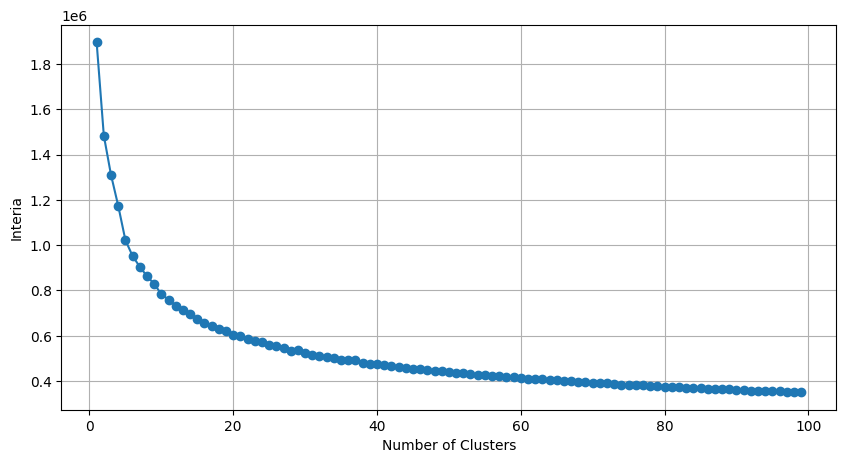

In [19]:
optimize_k_means(X_scaled, 100)

Applying K Means and MiniBatch Clustering

In [7]:
kmeans = KMeans(n_clusters=60, random_state=1)
mini_Batch_Kmeans = MiniBatchKMeans(n_clusters=60, random_state=1)

In [15]:
kmeans.fit(X_scaled)
mini_Batch_Kmeans.fit(X_scaled)

MiniBatchKMeans(n_clusters=60, random_state=1)

In [16]:
song_data['miniKmean_60'] = mini_Batch_Kmeans.labels_


In [10]:
song_data

,artist,song,emotion,variance,Genre,Release Date,Key,Tempo,Loudness,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness,miniKmean_60
0,ABBA,She's My Kind Of Girl,joy,0.447619,pop,2014,F Maj,128,-6.00,No,31,78,56,60,3,31,7,0,53
1,ABBA,"Andante, Andante",love,0.202222,pop,1980,A# Maj,102,-10.72,No,59,36,52,38,2,7,68,0,34
2,ABBA,As Good As New,sadness,0.300881,pop,1979,E Maj,139,-5.70,No,50,78,85,97,3,8,20,2,45
3,ABBA,Bang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0,25
4,ABBA,Bang-A-Boomerang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236983,(Eri Sasaki),Gate Of Steiner,sadness,0.833514,"Unknown,Unknown,Unknown",2018,D min,148,-6.44,No,41,61,41,37,4,14,20,0,4
236984,(Elena Tsagrinou),El Diablo,love,0.833514,"Unknown,Unknown,Unknown",2021,A min,114,-7.78,No,51,66,66,62,13,84,0,0,9
236985,(Dima Bilan),Believe,joy,0.833514,"Unknown,Unknown,Unknown",2009,C min,134,-6.72,No,36,73,55,24,5,22,5,0,58
236986,(Ani Lorak),Shady Lady,joy,0.833514,"Unknown,Unknown,Unknown",2009,F# min,128,-13.00,No,37,70,71,77,5,7,5,0,7


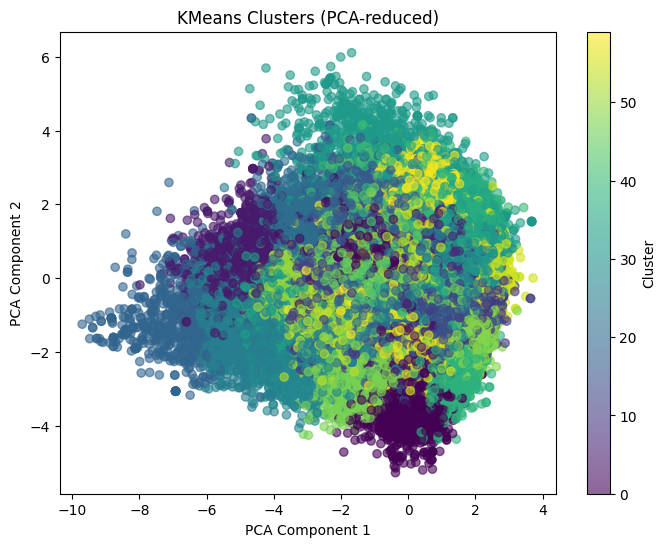

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=song_data['kmean_10'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters (PCA-reduced)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [14]:
# unique_genres = set()
# for genre_list in song_data['Genre']:
#     genres = [g.strip() for g in genre_list.split(',')]
#     unique_genres.update(genres)

# print(sorted(unique_genres))
print(song_data['Genre'].value_counts().head(35))

Genre
Unknown,Unknown,Unknown                       50019
pop                                           46883
rap                                           33204
alternative                                   19049
hip-hop                                       17317
rock                                          12956
folk                                          10620
metal                                         10491
soul                                           8741
electronic                                     5144
jazz                                           4302
progressive                                    3026
christian                                      2881
soundtrack                                     2576
reggae                                         1957
comedy                                         1031
world                                           308
xmas                                            300
Unknown                                         289
countr

In [13]:
unique_genres = set()

for genre_str in song_data['Genre']:
    genres = [g.strip() for g in genre_str.split(',')]
    unique_genres.update(genres)

print(sorted(unique_genres))

['-1001333387036', '-1001578764788', '-1001686404118', '-1001747063611', '-1001819731063', '-1001854528204', '-j013fh', '00s', '1', '10 of 10 stars', '10s', '116 bpm', '118 bpm', '12', '1208fh', '123', '123 drippy sappy', '13 reasons why', '1301fh', '17', '1920s', '1930', '1962', '1964', '1966', '1968', '1971', '1973', '1977', '1978', '1981', '1982', '1985', '1986', '1987', '1988', '1990s', '1991', '1992', '1993', '1998', '1Live Fiehe', '1M', '2 stars', '2000', '2000s', '2001', '2004', '2008', '2009', '2010', '2010s', '2010s country rock', '2010s funk blues', '2011', '2012', '2013', '2013 single', '2014', '2014 single', '2015', '2015 gif', '2015 single', '2016', '2016 Loved', '2016 single', '2017', '2017 single', '2018', '2018 single', '2019', '2020', '2020 single', '2020s', '2021', '2022', '2022 single', '20s', '20th Century Classical', '21st century in music', '291ooo', '294o00', '2k11 mix', '2step', '3', '3 stars', '30 Strand Grass', '30s', '4 Stars', '40s', '420', '5 times or less'

In [12]:
test_song = song_data.iloc[[4456]] # Best I Ever Had -Drake
print(test_song)


     artist             song  ... Instrumentalness  miniKmean_60
4456  Drake  Best I Ever Had  ...                0            26

[1 rows x 19 columns]


In [13]:
test_song_cluster_id = test_song['miniKmean_60'].iloc[0]
cluster_list = song_data[song_data['miniKmean_60'] == test_song_cluster_id].copy()
print(len(cluster_list))
for songName in cluster_list['song']:
        print(f" - {songName}")

3743
 - Goodbye
 - You Never Satisfy Me
 - Sing For Me
 - Beautiful People Say
 - Best I Ever Had
 - Up All Night
 - Buffalo Bill
 - Another Time, Another Place
 - Gone For Good
 - Pain
 - Imma Do It
 - Pain
 - Think For Yourself
 - Run
 - Empire State Of Mind
 - Ghetto Vet
 - Halls Of Illusions
 - I Stab People
 - If You Can't Beat 'Em Join 'Em
 - Like It Like That
 - Is She Gon Pop
 - The Good Son Part 1
 - Wet Dreamz
 - Heaven
 - Coyote
 - Trucker Anthem
 - Melodies From Heaven
 - Lead The Parade
 - Breakin' My Heart
 - Fly In
 - Until It Breaks
 - What We Don't Know
 - Live For You
 - Shiver
 - Done Too Soon
 - Didn't I See This Movie?
 - Could've Had Everything
 - Everything I Love
 - Brighton Rock
 - The Gloaming
 - First Place
 - Making Plans For Nigel
 - Grey Lagoons
 - Deez Hollywood Nights
 - Desperate Times Desperate Measures
 - Young And Aspiring
 - Dreams
 - Force Without Violence
 - Revolution
 - You A Me Baby
 - Chewy
 - Man
 - On The Silent Wings Of Freedom
 - Go Crazy


Computer Cosine similarity to the Cluster list

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
test_vector = test_song[features]
cluster_vectors = cluster_list[features]

similarities = cosine_similarity(test_vector, cluster_vectors)[0]
cluster_list['similarities'] = similarities

recommendations = cluster_list.sort_values(by='similarities', ascending=False)
print(recommendations[['artist', 'song', 'similarities', 'Genre', 'Popularity']].head(20))


                               artist  ... Popularity
4456                            Drake  ...         80
192810                          Drake  ...         79
193036                          Drake  ...         79
193084                          Drake  ...         79
93296                 Statik Selektah  ...         21
88206                       Tech N9ne  ...         24
189224                         Eminem  ...         43
97190                          Skillz  ...          3
198968                    Danny Brown  ...         40
193401                    Doujah Raze  ...         29
69684                      Vinnie Paz  ...         33
89427                     Talib Kweli  ...          8
223978                         Az Izz  ...          1
23796                         America  ...         75
161454                    Joey Bada$$  ...         38
219802              Benny the Butcher  ...         47
201147                      DEMONDICE  ...         40
104923                  Royc